In [1]:
import os
import pandas as pd
import numpy as np
import flopy as fp
import flopy.utils as fu
import matplotlib.pyplot as plt
import mfexport
import rasterio
from pyproj import CRS
from affine import Affine

In [2]:
model_ws = '../neversink_mf6/'
outpath = '../neversink_mf6/postproc'
simname = 'mfsim.nam'

In [3]:
if not os.path.exists(outpath):
    os.makedirs(outpath)

## Load up the MF6 model

In [4]:
sim = fp.mf6.MFSimulation.load(simname, 'mf6', sim_ws=model_ws)

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package ic...
    loading package npf...
    loading package rch...
    loading package oc...
    loading package wel...
    loading package obs...
    loading package chd...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 176 based on size of stress_period_data
    loading package sfr...
  loading ims package neversink...


In [5]:
m = sim.get_model()

## export some GIS treats

In [6]:
grid = mfexport.MFexportGrid(delr=m.dis.delr.array, # grid spacing in meters
                             delc=m.dis.delc.array , 
                             
                             xul=1742955.0, yul=2292285.0, # upper left corner in CRS
                             epsg=5070 
                            )

mfexport.export(m, grid, output_path=outpath)

In [8]:
# added sfr export -- SFR export not supported using the method above. 

mf6_sfr_stage_file=os.path.join(model_ws,'neversink.sfr.stage.bin')
mf6_sfr_budget_file=os.path.join(model_ws,'neversink.sfr.cbc')

outfiles = mfexport.export_sfr_results(mf6_sfr_stage_file=mf6_sfr_stage_file,
                                       mf6_sfr_budget_file=mf6_sfr_budget_file,
                                       model=m,
                                       grid=grid,
                                       output_length_units='meters',
                                       output_time_units='days',
                                       output_path=outpath
                                       )

Exporting SFR results...
file: ../neversink_mf6/neversink.sfr.stage.bin
file: ../neversink_mf6/neversink.sfr.cbc
Getting data from ../neversink_mf6/neversink.sfr.cbc...
for variables: FLOW-JA-FACE GWF RAINFALL EVAPORATION RUNOFF EXT-INFLOW EXT-OUTFLOW STORAGE AUXILIARY
reading FLOW-JA-FACE from
../neversink_mf6/neversink.sfr.cbc...
finished in 0.05s

aggregating FLOW-JA-FACE results...
loop took 0.04s
DataFrame construction took 0.03s
finished in 0.07s

reading GWF from
../neversink_mf6/neversink.sfr.cbc...
finished in 0.00s

reading RAINFALL from
../neversink_mf6/neversink.sfr.cbc...
finished in 0.01s

reading EVAPORATION from
../neversink_mf6/neversink.sfr.cbc...
finished in 0.02s

reading RUNOFF from
../neversink_mf6/neversink.sfr.cbc...
finished in 0.03s

reading EXT-INFLOW from
../neversink_mf6/neversink.sfr.cbc...
finished in 0.00s

reading EXT-OUTFLOW from
../neversink_mf6/neversink.sfr.cbc...
finished in 0.00s

reading STORAGE from
../neversink_mf6/neversink.sfr.cbc...
finished

In [ ]:
headsfile = os.path.join(model_ws,'neversink.hds')

mfexport.export_heads(headsfile,
                      grid, 
                      hdry=m.hnoflo, 
                      hnflo=m.hnoflo, 
                      kstpkper=(0, 0), # steady state one stress period
                      output_path=outpath,
                      interval=20, # meters
                     ) 


## Examine the mass balance overall

In [9]:
df_flux, _ = fu.Mf6ListBudget(os.path.join(model_ws,'neversink.list')).get_dataframes()
percdisc = df_flux.PERCENT_DISCREPANCY.values[0]
#budget_df = pd.DataFrame({'obs':percdisc})
#budget_df.index = ['PERC_DISC']
#budget_df

In [10]:
percdisc

-0.0

In [11]:
mfl6 = fu.Mf6ListBudget(os.path.join(model_ws,'neversink.list'))
df_flux, df_vol = mfl6.get_dataframes()

In [12]:
df_flux_backup = df_flux.copy()

In [13]:
df_flux = df_flux_backup.copy()
df_flux

,WEL_IN,RCH_IN,CHD_IN,SFR_IN,TOTAL_IN,WEL_OUT,RCH_OUT,CHD_OUT,SFR_OUT,TOTAL_OUT,IN-OUT,PERCENT_DISCREPANCY
1970-01-02,0.0,489968.1875,10305.591797,22787.8125,523061.5625,9881.269531,0.0,12862.643555,500318.03125,523061.9375,-0.3646,-0.0


In [14]:
outcols = [i for i in df_flux.columns if "OUT" in i]
for i in outcols:
    df_flux[i] *= -1

In [15]:
df_flux

,WEL_IN,RCH_IN,CHD_IN,SFR_IN,TOTAL_IN,WEL_OUT,RCH_OUT,CHD_OUT,SFR_OUT,TOTAL_OUT,IN-OUT,PERCENT_DISCREPANCY
1970-01-02,0.0,489968.1875,10305.591797,22787.8125,523061.5625,-9881.269531,-0.0,-12862.643555,-500318.03125,-523061.9375,0.3646,-0.0


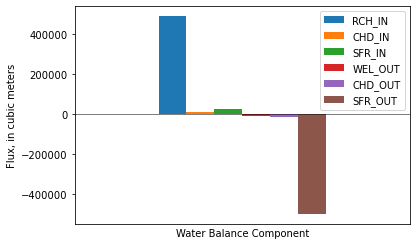

In [22]:
df_flux[[i for i in df_flux.columns if ("PERCE" not in i) & ("WEL_IN" not in i) & ("RCH_OUT" not in i) & ("TOT" not in i) & ("N-O" not in i) ]].plot.bar()
plt.xticks([])
plt.xlabel('Water Balance Component')
plt.ylabel('Flux, in cubic meters')
plt.axhline(0, linewidth=0.5, c='k')

## top of model

In [ ]:
plt.figure(figsize=(6,6))
top = m.dis.top.array.copy()
top[top<-999] = np.nan
plt.imshow(top)
plt.colorbar()

## load up the heads

In [ ]:
sim.simulation_data.mfdata.output_keys()

In [ ]:
# steady state so get rid of time dimension
heads = np.squeeze(sim.simulation_data.mfdata['neversink', 'HDS', 'HEAD'])

In [ ]:
heads2 = heads.copy()

In [ ]:
plt.imshow(heads[3])
plt.colorbar()

In [ ]:
m.hnoflo

In [ ]:
wt = fu.postprocessing.get_water_table(heads, m.hnoflo)
wt[wt==m.hnoflo] = np.nan

In [ ]:
plt.imshow(wt)
plt.colorbar()

In [ ]:
# mask out the inactive areas
heads[heads==m.hnoflo] = np.nan
#heads[heads<-100] = np.nan

In [ ]:
for i in range(m.dis.nlay.array):
    plt.figure(figsize=(6,6))
    plt.imshow(heads[i,:,:])
    plt.colorbar()
    plt.title('heads layer {}'.format(i))

In [ ]:
for i in range(m.npf.k.array):
    plt.figure(figsize=(6,6))
    plt.imshow(heads[i,:,:])
    plt.colorbar()
    plt.title('heads layer {}'.format(i))

In [ ]:
m.

In [ ]:
flooded = wt-m.dis.top.data
flooded[flooded<0] = np.nan
#flooded[flooded>10] = 10
plt.figure(figsize=(10,10))
plt.imshow(flooded)
plt.title('Excess head in flooded cells, in meters')
plt.colorbar()
plt.savefig('flooding_rep_model.pdf', dpi=600)

In [ ]:

flooded[np.isnan(flooded)]=-9999.

outfile = 'flooding.tif'
raster_outpath = os.path.join(outpath, outfile)

dataset = rasterio.open(
    raster_outpath, 
    'w', 
    driver='GTiff',
    height = flooded.shape[0], 
    width = flooded.shape[1],
    count=1,
    nodata = -9999.0,
    dtype=str(flooded.dtype),
    crs = CRS.from_epsg(5070),
    transform=Affine(50.0, 0.0, 1742955.0,
                     0.0, -50.0, 2292285.0),
)

dataset.write(flooded, 1)
dataset.close()


In [ ]:
with rasterio.open('../k_processing/V2_Layer{}_K.tif'.format(1)) as src:
    crs = src.crs
    meta = src.meta
    nodata = meta['nodata']
    K_tuple = src.read(1, masked=True),
    K_data = K_tuple[0].data.astype(float)

    

In [ ]:
crs

In [ ]:
    
newK = K_data.copy()



outfile = os.path.join(outpath,'rasters/flooded_cells.tif')
dataset = rasterio.open(
    outfile, 
    'w', 
    driver=meta['driver'],
    height = newK.shape[0], 
    width = newK.shape[1],
    count=1,
    nodata = nodata,
    dtype=str(newK.dtype),
    crs = crs,
    compress='lzw',
    transform=meta['transform']
)

dataset.write(flooded, 1)
dataset.close()

In [ ]:

for i in range(m.dis.nlay.array):
    plt.figure(figsize=(6,6))
    flooded = heads[i,:,:]-m.dis.top.array
    flooded[flooded < 0]=np.nan
    plt.imshow(flooded)
    plt.colorbar()
    plt.title('flooded layer {}'.format(i))

## checking out idomain

In [ ]:
idm = m.dis.idomain.array

In [ ]:
for i in range(m.dis.nlay.array):
    plt.figure(figsize=(6,6))
    plt.imshow(idm[i,:,:])
    plt.colorbar()
    plt.title('idm layer {}'.format(i))

## Plot up the model bottoms

In [ ]:
botm = m.dis.botm.array
botm[botm<-999] = np.nan
for i in range(m.dis.nlay.array):
    plt.figure(figsize=(6,6))
    plt.imshow(botm[i,:,:])
    plt.colorbar()
    plt.title('botm layer {}'.format(i))

## Plot up the model thicknesses


In [ ]:
botm[botm==-9999] = np.nan
thick=[]
thick.append(m.dis.top.array - m.dis.botm.array[0])
for i in range(3):
    thick.append(m.dis.botm.array[i]-m.dis.botm.array[i+1])
for i in range(m.dis.nlay.array):
    plt.figure(figsize=(6,6))
    plt.imshow(thick[i])
    plt.colorbar()
    plt.title('thick layer {}'.format(i))

In [ ]:
thick[-1][thick[-1]<30] = np.nan
plt.imshow(thick[-1])
plt.colorbar()